# Example Prediction Temperature Working on First Month To Predict The temperature of Weekly Nasa Dataset

In [7]:
import pandas as pd
dataset = pd.read_csv('Monthone.csv')
dataset.columns

Index(['ALLSKY_KT', 'WS2M', 'T2M', 'PS', 'WS10M', 'QV2M', 'RH2M'], dtype='object')

In [8]:
from scipy.stats import zscore
import pandas as pd

# Create a sample df
df = pd.DataFrame(dataset)

# Calculate the zscores and drop zscores into new column
df['ALLSKY_KT'] = zscore(df['ALLSKY_KT'])
df['WS2M'] = zscore(df['WS2M'])
df['T2M'] = zscore(df['T2M'])
df['PS'] = zscore(df['PS'])
df['WS10M'] = zscore(df['WS10M'])
df['QV2M'] = zscore(df['QV2M'])
df['RH2M'] = zscore(df['RH2M'])
data = df
display(data)

,ALLSKY_KT,WS2M,T2M,PS,WS10M,QV2M,RH2M
0,-0.967563,0.417607,0.027935,-0.843857,0.423088,-0.315555,-0.531175
1,-0.797783,0.535963,0.123457,-1.115432,0.511928,-0.259463,-0.647691
2,-0.543113,-0.577977,0.338383,-0.715216,-0.543048,-0.025749,-0.427142
3,-0.458223,-0.591902,0.553308,0.456846,-0.604126,0.544513,0.282362
4,3.107156,-1.127985,1.013010,0.742715,-1.142719,0.086434,-0.531175
...,...,...,...,...,...,...,...
1204,-1.392013,0.194819,1.580174,-1.329834,0.123253,1.114776,0.268837
1205,-1.392013,0.146084,1.210025,-1.229780,0.073280,1.451325,0.997067
1206,-1.137343,0.494190,0.989129,-1.258366,0.467508,0.376239,-0.393851
1207,-1.222233,0.313175,0.630920,-1.115432,0.312038,0.712788,0.249071


In [9]:
data.shape

(1209, 7)

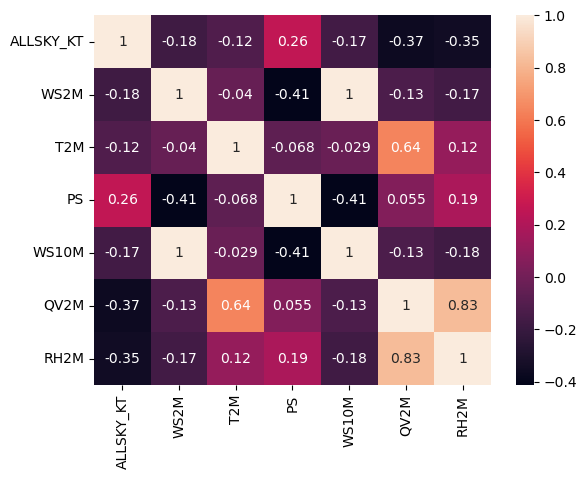

In [10]:
import seaborn as sns 
import matplotlib.pyplot as plt
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [11]:
data.head(5)

,ALLSKY_KT,WS2M,T2M,PS,WS10M,QV2M,RH2M
0,-0.967563,0.417607,0.027935,-0.843857,0.423088,-0.315555,-0.531175
1,-0.797783,0.535963,0.123457,-1.115432,0.511928,-0.259463,-0.647691
2,-0.543113,-0.577977,0.338383,-0.715216,-0.543048,-0.025749,-0.427142
3,-0.458223,-0.591902,0.553308,0.456846,-0.604126,0.544513,0.282362
4,3.107156,-1.127985,1.013010,0.742715,-1.142719,0.086434,-0.531175


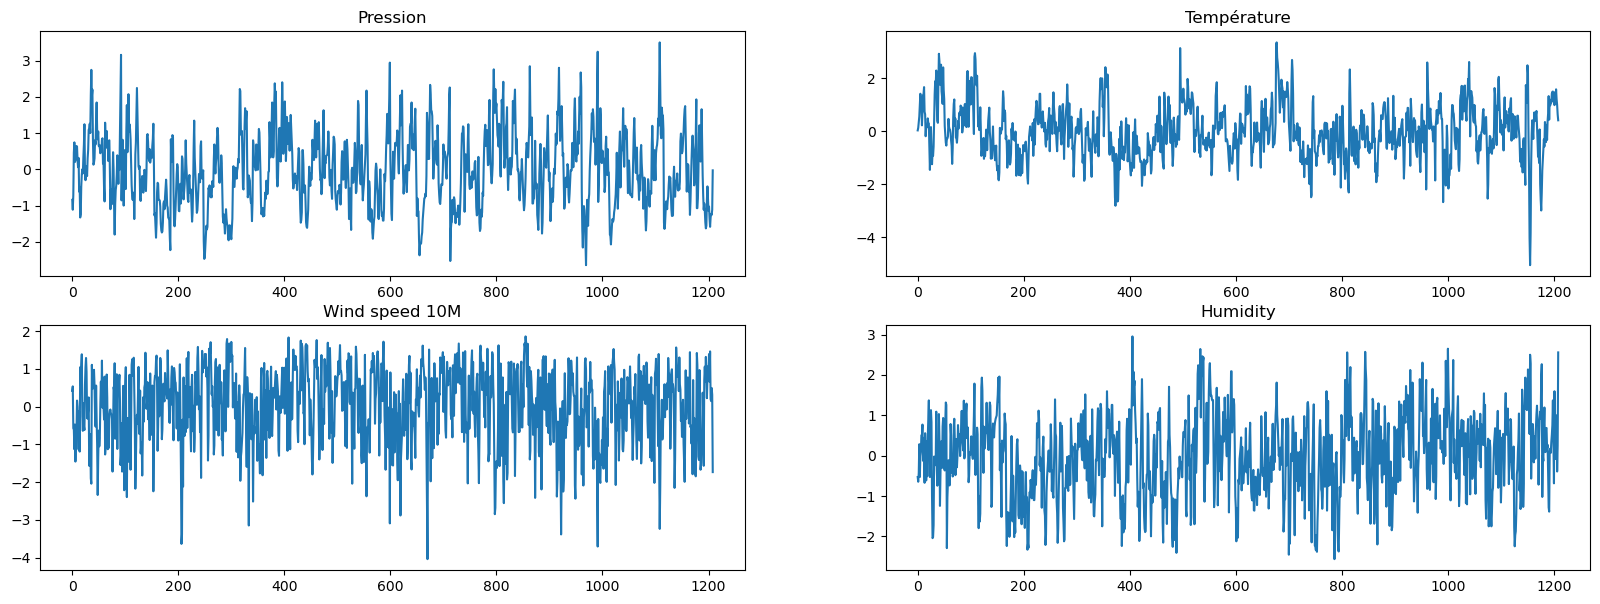

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,7))
# Évolution de la pression
ax1 = fig.add_subplot(221)
plt.plot(data['PS'])
ax1.title.set_text('Pression')
# Évolution de la température
ax2 = fig.add_subplot(222)
plt.plot(data['T2M'])
ax2.title.set_text('Température')
# Évolution de la vont
ax3 = fig.add_subplot(223)
plt.plot(data['WS2M'])
ax3.title.set_text('Wind speed 10M')
# Évolution du déficit de himidité de vapeur
ax4 = fig.add_subplot(224)
plt.plot(data['RH2M'])
ax4.title.set_text('Humidity')
# Evolution de radation
#ax5 = fig.add_subplot(225)
#plt.plot(data['Radiation'])
#ax5.title.set_text('Radation')

plt.show()

In [13]:
split_fraction = 0.80
split_idx = int(split_fraction * len(data))
# Train: on conserve les 80% premières lignes
train_data = data.loc[0:split_idx-1].values
# Test: on conserve les 20% dernières lignes
val_data = data.loc[split_idx:].values
print(f"Jeu d'apprentissage : {train_data.shape}, jeu d'évaluation : {val_data.shape}")

Jeu d'apprentissage : (967, 7), jeu d'évaluation : (242, 7)


### Train The NN and obtimise with descente de gradient

In [14]:
# Importation 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as plt

In [15]:
# Création du jeu d'entraînement
sampling_rate = 1 # Fréquence d'échantillonnage
sequence_length = 120  # Longueur de la séquence
batch_size = 256 # Taille de batch

# Création du jeu d'entraînement: contient Temperature, Pressure, Humidity, WindSpeed, day length
X_train = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[:, (0,1,3,4,5,6)],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[:, 2],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

dataset_train = tf.data.Dataset.zip((X_train, y_train))
# Création du jeu d'évaluation

X_val = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[:, (0,1,3,4,5,6)],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[:, 2],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

dataset_val = tf.data.Dataset.zip((X_val, y_val))

# Training The RNN To Predict First Month

In [16]:
# from tensorflow import keras

dimension = train_data.shape[1]-1
inputs = keras.layers.Input(shape=(sequence_length, dimension))
gru_out = keras.layers.GRU(dimension, return_sequences=True)(inputs)
dense_out = keras.layers.Dense(dimension, activation='relu')(gru_out)
outputs = keras.layers.Dense(1)(dense_out)

model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
learning_rate = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 6)]          0         
                                                                 
 gru (GRU)                   (None, 120, 6)            252       
                                                                 
 dense (Dense)               (None, 120, 6)            42        
                                                                 
 dense_1 (Dense)             (None, 120, 1)            7         
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [18]:
epochs = 100
model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
)

Epoch 1/100
4/4 [==============================] - 4s 284ms/step - loss: 1.2423 - val_loss: 1.3731
Epoch 2/100
4/4 [==============================] - 0s 98ms/step - loss: 1.2036 - val_loss: 1.3541
Epoch 3/100
4/4 [==============================] - 0s 94ms/step - loss: 1.1690 - val_loss: 1.3365
Epoch 4/100
4/4 [==============================] - 0s 100ms/step - loss: 1.1376 - val_loss: 1.3200
Epoch 5/100
4/4 [==============================] - 0s 99ms/step - loss: 1.1093 - val_loss: 1.3046
Epoch 6/100
4/4 [==============================] - 0s 94ms/step - loss: 1.0840 - val_loss: 1.2902
Epoch 7/100
4/4 [==============================] - 0s 99ms/step - loss: 1.0612 - val_loss: 1.2769
Epoch 8/100
4/4 [==============================] - 0s 94ms/step - loss: 1.0412 - val_loss: 1.2645
Epoch 9/100
4/4 [==============================] - 0s 100ms/step - loss: 1.0231 - val_loss: 1.2529
Epoch 10/100
4/4 [==============================] - 0s 99ms/step - loss: 1.0073 - val_loss: 1.2419
Epoch 11/100
4/4

4/4 [==============================] - 0s 99ms/step - loss: 0.1000 - val_loss: 0.2154
Epoch 84/100
4/4 [==============================] - 0s 98ms/step - loss: 0.0960 - val_loss: 0.2092
Epoch 85/100
4/4 [==============================] - 0s 93ms/step - loss: 0.0923 - val_loss: 0.2035
Epoch 86/100
4/4 [==============================] - 0s 93ms/step - loss: 0.0890 - val_loss: 0.1982
Epoch 87/100
4/4 [==============================] - 0s 94ms/step - loss: 0.0858 - val_loss: 0.1933
Epoch 88/100
4/4 [==============================] - 0s 105ms/step - loss: 0.0829 - val_loss: 0.1885
Epoch 89/100
4/4 [==============================] - 0s 116ms/step - loss: 0.0802 - val_loss: 0.1840
Epoch 90/100
4/4 [==============================] - 0s 105ms/step - loss: 0.0776 - val_loss: 0.1797
Epoch 91/100
4/4 [==============================] - 0s 105ms/step - loss: 0.0752 - val_loss: 0.1756
Epoch 92/100
4/4 [==============================] - 0s 99ms/step - loss: 0.0729 - val_loss: 0.1718
Epoch 93/100
4/4 [=

In [19]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import scatter
def show_plot(predicted_data, true_data):
    plt.title('Prédiction synchrone')
    plt.plot(predicted_data, "rx", label="Temperature prédite")
    plt.plot(true_data, ".-", label="Vraie Temperature")
    plt.legend()
    plt.xlabel("Pas de temps")
    plt.show()
    return

4/4 [==============================] - 1s 14ms/step


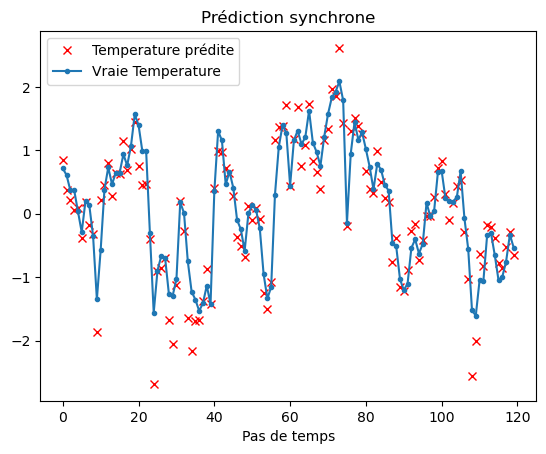

In [20]:
for x, y in dataset_val.take(3):
     show_plot(y[0].numpy(), model.predict(x)[0])

In [21]:
mean_absolute_error = tf.keras.losses.MeanAbsoluteError()
error = 0

for x, y in dataset_val:
    y_pred = model(x)
    error += mean_absolute_error(y, y_pred).numpy()

print(f"Erreur absolue moyenne : {error/len(dataset_val):.5f}")


Erreur absolue moyenne : 0.23899


## Prédiction de la température future

In [22]:
past_length = 120
future_step = 1

label_start = past_length + future_step  # Début de la séquence des labels
label_end = label_start + split_idx  # Fin de la séquence des labels

x_train = train_data
y_train = data[label_start:label_end][['T2M']]

x_end = len(val_data) - past_length - future_step # Fin de la séquence des données d'entrées en validation

label_start = split_idx + past_length + future_step # Début de la séquence des labels en validation
x_val = val_data[:x_end]
y_val = data[label_start:][['T2M']]

In [23]:
batch_size = 256
step_size = 1 # Facteur d'échantillonnage
sequence_length = int(past_length / step_size)

dataset_train = tf.keras.utils.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step_size,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step_size,
    batch_size=batch_size,
)

In [51]:
learning_rate = 0.001

input_dim = train_data.shape[1]
hidden_dim = 32
inputs = keras.layers.Input(shape=(sequence_length, input_dim))
gru_out = keras.layers.GRU(hidden_dim,recurrent_activation='sigmoid',)(inputs)
dense_out = keras.layers.Dense(32, activation='sigmoid')(gru_out)
outputs = keras.layers.Dense(1)(dense_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 gru_7 (GRU)                 (None, 32)                3936      
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [59]:
epochs = 500

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
)

Epoch 1/500
4/4 [==============================] - 0s 118ms/step - loss: 0.5015 - val_loss: 3.5364
Epoch 2/500
4/4 [==============================] - 1s 127ms/step - loss: 0.4976 - val_loss: 3.4774
Epoch 3/500
4/4 [==============================] - 1s 129ms/step - loss: 0.4936 - val_loss: 3.4161
Epoch 4/500
4/4 [==============================] - 1s 125ms/step - loss: 0.4896 - val_loss: 3.3529
Epoch 5/500
4/4 [==============================] - 1s 127ms/step - loss: 0.4855 - val_loss: 3.2884
Epoch 6/500
4/4 [==============================] - 0s 119ms/step - loss: 0.4813 - val_loss: 3.2230
Epoch 7/500
4/4 [==============================] - 1s 122ms/step - loss: 0.4770 - val_loss: 3.1571
Epoch 8/500
4/4 [==============================] - 1s 117ms/step - loss: 0.4728 - val_loss: 3.0910
Epoch 9/500
4/4 [==============================] - 1s 123ms/step - loss: 0.4684 - val_loss: 3.0251
Epoch 10/500
4/4 [==============================] - 1s 123ms/step - loss: 0.4640 - val_loss: 2.9595
Epoch 11/

4/4 [==============================] - 1s 127ms/step - loss: 0.2299 - val_loss: 1.3872
Epoch 84/500
4/4 [==============================] - 1s 124ms/step - loss: 0.2293 - val_loss: 1.2011
Epoch 85/500
4/4 [==============================] - 1s 124ms/step - loss: 0.2201 - val_loss: 1.3505
Epoch 86/500
4/4 [==============================] - 1s 124ms/step - loss: 0.2190 - val_loss: 1.2313
Epoch 87/500
4/4 [==============================] - 1s 122ms/step - loss: 0.2181 - val_loss: 1.1973
Epoch 88/500
4/4 [==============================] - 1s 123ms/step - loss: 0.2144 - val_loss: 1.2881
Epoch 89/500
4/4 [==============================] - 1s 124ms/step - loss: 0.2128 - val_loss: 1.1870
Epoch 90/500
4/4 [==============================] - 1s 128ms/step - loss: 0.2116 - val_loss: 1.2551
Epoch 91/500
4/4 [==============================] - 1s 123ms/step - loss: 0.2099 - val_loss: 1.2435
Epoch 92/500
4/4 [==============================] - 1s 125ms/step - loss: 0.2083 - val_loss: 1.2585
Epoch 93/500


4/4 [==============================] - 1s 134ms/step - loss: 0.1651 - val_loss: 1.2333
Epoch 165/500
4/4 [==============================] - 1s 129ms/step - loss: 0.1643 - val_loss: 1.2889
Epoch 166/500
4/4 [==============================] - 1s 142ms/step - loss: 0.1634 - val_loss: 1.3030
Epoch 167/500
4/4 [==============================] - 1s 143ms/step - loss: 0.1627 - val_loss: 1.3252
Epoch 168/500
4/4 [==============================] - 1s 129ms/step - loss: 0.1620 - val_loss: 1.3594
Epoch 169/500
4/4 [==============================] - 1s 123ms/step - loss: 0.1612 - val_loss: 1.4109
Epoch 170/500
4/4 [==============================] - 1s 124ms/step - loss: 0.1605 - val_loss: 1.4603
Epoch 171/500
4/4 [==============================] - 1s 123ms/step - loss: 0.1598 - val_loss: 1.5019
Epoch 172/500
4/4 [==============================] - 1s 136ms/step - loss: 0.1591 - val_loss: 1.5758
Epoch 173/500
4/4 [==============================] - 1s 125ms/step - loss: 0.1585 - val_loss: 1.6194
Epoc

4/4 [==============================] - 1s 150ms/step - loss: 0.1304 - val_loss: 1.7606
Epoch 246/500
4/4 [==============================] - 1s 137ms/step - loss: 0.1301 - val_loss: 1.8813
Epoch 247/500
4/4 [==============================] - 1s 137ms/step - loss: 0.1297 - val_loss: 1.8667
Epoch 248/500
4/4 [==============================] - 1s 132ms/step - loss: 0.1294 - val_loss: 2.0680
Epoch 249/500
4/4 [==============================] - 1s 127ms/step - loss: 0.1291 - val_loss: 1.9504
Epoch 250/500
4/4 [==============================] - 1s 131ms/step - loss: 0.1291 - val_loss: 2.3325
Epoch 251/500
4/4 [==============================] - 1s 123ms/step - loss: 0.1292 - val_loss: 1.9504
Epoch 252/500
4/4 [==============================] - 1s 123ms/step - loss: 0.1303 - val_loss: 2.7490
Epoch 253/500
4/4 [==============================] - 1s 123ms/step - loss: 0.1321 - val_loss: 1.7496
Epoch 254/500
4/4 [==============================] - 1s 123ms/step - loss: 0.1376 - val_loss: 3.2909
Epoc

4/4 [==============================] - 1s 139ms/step - loss: 0.1102 - val_loss: 1.3410
Epoch 327/500
4/4 [==============================] - 1s 122ms/step - loss: 0.1099 - val_loss: 1.3498
Epoch 328/500
4/4 [==============================] - 1s 133ms/step - loss: 0.1097 - val_loss: 1.3751
Epoch 329/500
4/4 [==============================] - 1s 132ms/step - loss: 0.1094 - val_loss: 1.3813
Epoch 330/500
4/4 [==============================] - 1s 132ms/step - loss: 0.1092 - val_loss: 1.4114
Epoch 331/500
4/4 [==============================] - 1s 138ms/step - loss: 0.1089 - val_loss: 1.4161
Epoch 332/500
4/4 [==============================] - 1s 127ms/step - loss: 0.1086 - val_loss: 1.4515
Epoch 333/500
4/4 [==============================] - 1s 127ms/step - loss: 0.1084 - val_loss: 1.4549
Epoch 334/500
4/4 [==============================] - 1s 138ms/step - loss: 0.1081 - val_loss: 1.4931
Epoch 335/500
4/4 [==============================] - 1s 126ms/step - loss: 0.1079 - val_loss: 1.4983
Epoc

4/4 [==============================] - 1s 141ms/step - loss: 0.0954 - val_loss: 1.3888
Epoch 408/500
4/4 [==============================] - 1s 128ms/step - loss: 0.0951 - val_loss: 1.4241
Epoch 409/500
4/4 [==============================] - 1s 132ms/step - loss: 0.0954 - val_loss: 1.4416
Epoch 410/500
4/4 [==============================] - 1s 134ms/step - loss: 0.0975 - val_loss: 1.3609
Epoch 411/500
4/4 [==============================] - 1s 125ms/step - loss: 0.1014 - val_loss: 1.4402
Epoch 412/500
4/4 [==============================] - 1s 123ms/step - loss: 0.1019 - val_loss: 1.4312
Epoch 413/500
4/4 [==============================] - 1s 124ms/step - loss: 0.1049 - val_loss: 1.2629
Epoch 414/500
4/4 [==============================] - 1s 124ms/step - loss: 0.1237 - val_loss: 1.4732
Epoch 415/500
4/4 [==============================] - 1s 129ms/step - loss: 0.1204 - val_loss: 1.2313
Epoch 416/500
4/4 [==============================] - 1s 128ms/step - loss: 0.1118 - val_loss: 1.2652
Epoc

4/4 [==============================] - 1s 140ms/step - loss: 0.0865 - val_loss: 1.3828
Epoch 489/500
4/4 [==============================] - 1s 131ms/step - loss: 0.0858 - val_loss: 1.3273
Epoch 490/500
4/4 [==============================] - 1s 128ms/step - loss: 0.0854 - val_loss: 1.4077
Epoch 491/500
4/4 [==============================] - 1s 132ms/step - loss: 0.0850 - val_loss: 1.3202
Epoch 492/500
4/4 [==============================] - 1s 132ms/step - loss: 0.0848 - val_loss: 1.4012
Epoch 493/500
4/4 [==============================] - 1s 132ms/step - loss: 0.0847 - val_loss: 1.3272
Epoch 494/500
4/4 [==============================] - 1s 131ms/step - loss: 0.0846 - val_loss: 1.3841
Epoch 495/500
4/4 [==============================] - 1s 126ms/step - loss: 0.0845 - val_loss: 1.3272
Epoch 496/500
4/4 [==============================] - 1s 133ms/step - loss: 0.0842 - val_loss: 1.3714
Epoch 497/500
4/4 [==============================] - 1s 131ms/step - loss: 0.0842 - val_loss: 1.3249
Epoc

In [60]:
def show_plot(sequence, prediction, ground_truth, delta=future_step/step_size, title=None):
    plt.title(title)
    plt.plot(sequence.flatten(), ".-", label="Temperature")
    plt.plot(len(sequence) + delta, prediction, "go", label="Prédiction")
    plt.plot(len(sequence) + delta, ground_truth, "rx", label="Vraie Temperature")
    plt.legend()
    plt.xlim(-1, len(sequence) + delta + 3)
    plt.xlabel("Pas de temps")
    plt.show()

1/1 [==============================] - 0s 31ms/step


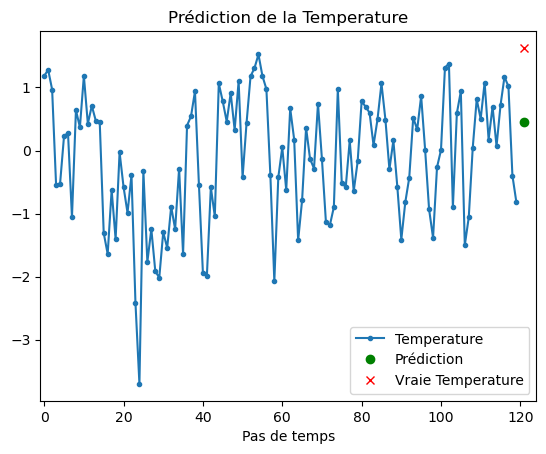

In [61]:
for x, y in dataset_val.take(5):
    show_plot(x[0][:, 1].numpy(), model.predict(x)[0], y[0].numpy(), title="Prédiction de la Temperature")

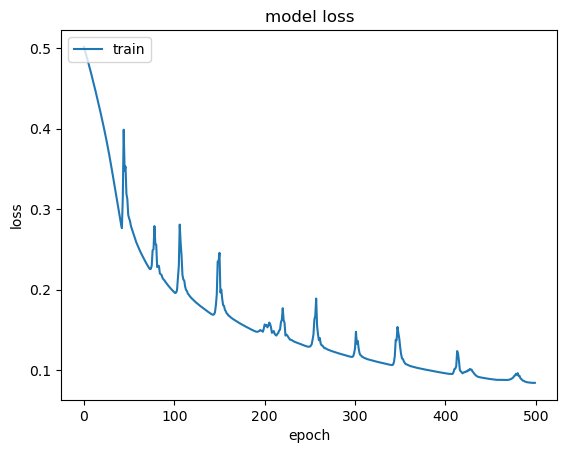

In [62]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()